In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 87.2 MB/s eta 0:00:00:00:010:01


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import os
import decord
import matplotlib.pyplot as plt
from decord import VideoReader, cpu
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths to dataset
violence_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence'
non_violence_path = '/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence'

# Parameters
img_size = 64
frame_count = 30
batch_size = 8

# Load videos using decord for faster processing
def load_videos(path, label):
    data = []
    print(f"Loading videos from: {path}")

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            vr = VideoReader(file_path, ctx=cpu(0))
            total_frames = len(vr)

            if total_frames < frame_count:
                continue

            frame_skip = max(total_frames // frame_count, 1)

            frames = [vr[i * frame_skip].asnumpy() for i in range(frame_count)]

            frames = [cv2.resize(frame, (img_size, img_size)) for frame in frames]

            if len(frames) == frame_count:
                data.append((np.array(frames), label))

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    print(f"Loaded {len(data)} videos from {path}")
    return data

violence_data = load_videos(violence_path, 1)
non_violence_data = load_videos(non_violence_path, 0)

# Combine and shuffle
data = violence_data + non_violence_data
np.random.shuffle(data)

X = np.array([item[0] for item in data])
y = np.array([item[1] for item in data])

# Normalize pixel values
X = X / 255.0

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Then split temp into validation (10%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)

# Check shapes
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# PyTorch Dataset
class VideoDataset(Dataset):
    def __init__(self, videos, labels):
        self.videos = torch.tensor(videos, dtype=torch.float32).permute(0, 4, 1, 2, 3)  # N, C, D, H, W
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        return self.videos[idx], self.labels[idx]


Using device: cuda
Loading videos from: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence
Loaded 1000 videos from /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence
Loading videos from: /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence
Loaded 999 videos from /kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence
Train: (1399, 30, 64, 64, 3), Validation: (200, 30, 64, 64, 3), Test: (400, 30, 64, 64, 3)


Epoch 1/5 - Loss: 0.4793, Train Acc: 77.17%
Validation Accuracy: 83.25%
Epoch 2/5 - Loss: 0.3273, Train Acc: 86.49%
Validation Accuracy: 85.25%
Epoch 3/5 - Loss: 0.2808, Train Acc: 88.68%
Validation Accuracy: 86.00%
Epoch 4/5 - Loss: 0.2244, Train Acc: 91.74%
Validation Accuracy: 86.75%
Epoch 5/5 - Loss: 0.1706, Train Acc: 95.00%
Validation Accuracy: 84.50%
Best Validation Accuracy: 86.75%


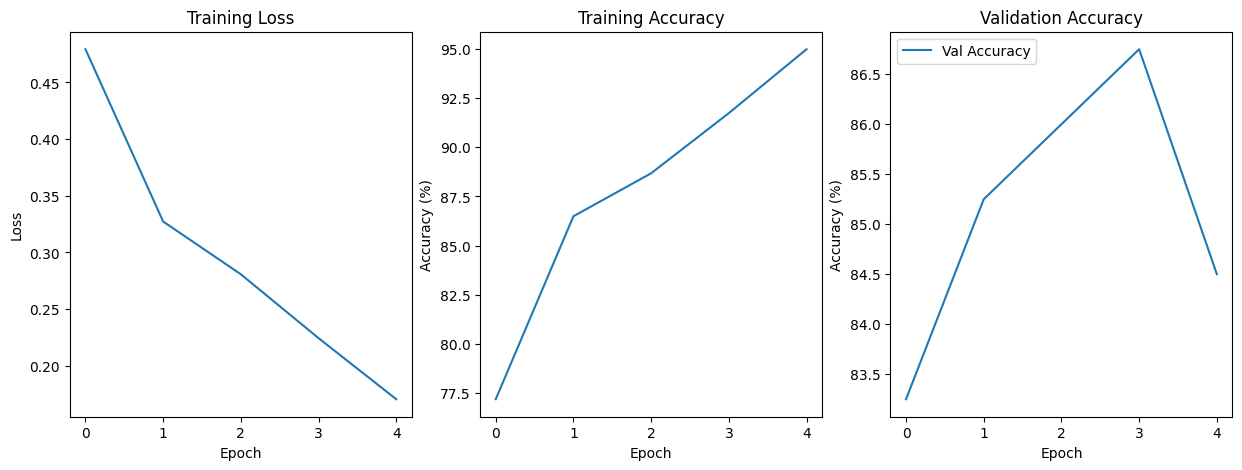

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


train_dataset = VideoDataset(X_train, y_train)
test_dataset = VideoDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 3D CNN Model
class ViolenceDetection3DCNN(nn.Module):
    def __init__(self):
        super(ViolenceDetection3DCNN, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.pool1 = nn.MaxPool3d((1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        self.pool2 = nn.MaxPool3d((2, 2, 2))

        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)
        self.pool3 = nn.MaxPool3d((2, 2, 2))

        self.flatten = nn.Flatten()

        self.fc1 = None  # Placeholder for dynamic input size
        self.fc2 = nn.Linear(512, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))

        x = self.flatten(x)

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)

        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViolenceDetection3DCNN().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10):
    model.train()
    loss_history, acc_history, val_acc_history = [], [], []

    best_val_acc = 0

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0

        for videos, labels in train_loader:
            videos, labels = videos.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(videos)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")

        # Validation Loop
        val_acc = evaluate(model, val_loader)
        val_acc_history.append(val_acc)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_violence_detection_3dcnn.pth')

        scheduler.step()

    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    return loss_history, acc_history, val_acc_history

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for videos, labels in loader:
            videos, labels = videos.to(device), labels.to(device)

            outputs = model(videos)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = 100 * correct / total
    print(f"Validation Accuracy: {acc:.2f}%")
    model.train()
    return acc

def plot_training_curves(loss_history, acc_history, val_acc_history):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 3, 2)
    plt.plot(acc_history, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')

    plt.subplot(1, 3, 3)
    plt.plot(val_acc_history, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')

    plt.legend()
    plt.show()

# Train the model
loss_history, acc_history, val_acc_history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=5)
plot_training_curves(loss_history, acc_history, val_acc_history)

# Save final model
torch.save(model.state_dict(), 'violence_detection_3dcnn_final.pth')


Epoch 1/5 - Loss: 0.4191, Train Acc: 81.56%
Validation Accuracy: 98.00%
Epoch 2/5 - Loss: 0.2882, Train Acc: 89.28%
Validation Accuracy: 86.50%
Epoch 3/5 - Loss: 0.2199, Train Acc: 92.35%
Validation Accuracy: 98.50%
Epoch 4/5 - Loss: 0.1792, Train Acc: 94.35%
Validation Accuracy: 97.00%
Epoch 5/5 - Loss: 0.1165, Train Acc: 95.93%
Validation Accuracy: 97.50%
Best model saved at the end.


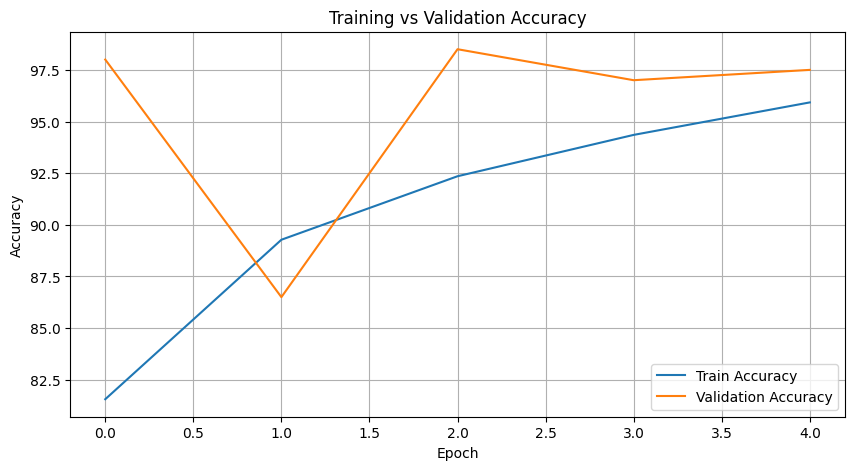

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import video
train_dataset = VideoDataset(X_train, y_train)
val_dataset = VideoDataset(X_val, y_val)
test_dataset = VideoDataset(X_test,y_test)
# Load pretrained I3D model
class I3DModel(nn.Module):
    def __init__(self, num_classes=2):
        super(I3DModel, self).__init__()

        self.i3d = video.mc3_18(pretrained=True)  # Load pretrained MC3_18 (a 3D ResNet variant)

        # Replace the classifier with a new one
        self.i3d.fc = nn.Sequential(
            nn.Linear(self.i3d.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.i3d(x)

# Data augmentation for video inputs
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Assume train_dataset and val_dataset are already defined
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model, Loss, Optimizer with L2 Regularization
model = I3DModel(num_classes=2).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

# Early Stopping Parameters
best_val_acc = 0
patience = 3
counter = 0

# def train_model(model, train_loader, val_loader, epochs):
#     global best_val_acc, counter

#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for videos, labels in train_loader:
#             videos, labels = videos.cuda(), labels.cuda()

#             optimizer.zero_grad()
#             outputs = model(videos)

#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             torch.cuda.empty_cache()

#             running_loss += loss.item()

#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         train_acc = 100 * correct / total

#         # Validation
#         model.eval()
#         val_acc = 0
#         correct = 0
#         total = 0

        # with torch.no_grad():
        #     for videos, labels in val_loader:
        #         videos, labels = videos.cuda(), labels.cuda()

        #         outputs = model(videos)
        #         _, predicted = torch.max(outputs, 1)
        #         total += labels.size(0)
        #         correct += (predicted == labels).sum().item()

        #     val_acc = 100 * correct / total

        # scheduler.step(val_acc)

        # print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")
        # print(f"Validation Accuracy: {val_acc:.2f}%")

        # # Early Stopping
        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     torch.save(model.state_dict(), 'best_i3d_model.pth')
        #     counter = 0
        # else:
        #     counter += 1

        # if counter >= patience:
        #     print("Early stopping triggered")
            # break
train_acc_list = []
val_acc_list = []
def train_model(model, train_loader, val_loader, epochs):
    global best_val_acc, counter
    best_model_wts = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for videos, labels in train_loader:
            videos, labels = videos.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(videos)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            torch.cuda.empty_cache()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        val_acc = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, labels in val_loader:
                videos, labels = videos.cuda(), labels.cuda()
                outputs = model(videos)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_acc = 100 * correct / total
            val_acc_list.append(val_acc)

        scheduler.step(val_acc)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Validation Accuracy: {val_acc:.2f}%")

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

    # Save the best model at the end
    if best_model_wts:
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), 'best_i3d_model.pth')
        print("Best model saved at the end.")
        
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_list, label='Train Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

train_model(model, train_loader, val_loader, epochs=5)

In [12]:
train_model(model, train_loader, val_loader, epochs=5)

Epoch 1/5 - Loss: 0.1227, Train Acc: 95.93%
Validation Accuracy: 94.75%
Epoch 2/5 - Loss: 0.0555, Train Acc: 98.50%
Validation Accuracy: 96.50%
Epoch 3/5 - Loss: 0.0411, Train Acc: 98.81%
Validation Accuracy: 96.00%
Epoch 4/5 - Loss: 0.0215, Train Acc: 99.19%
Validation Accuracy: 96.00%
Epoch 5/5 - Loss: 0.0574, Train Acc: 98.12%
Validation Accuracy: 95.00%
Early stopping triggered


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import video
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_on_test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.cuda()
            outputs = model(videos)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {acc * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Test Accuracy: 97.75%


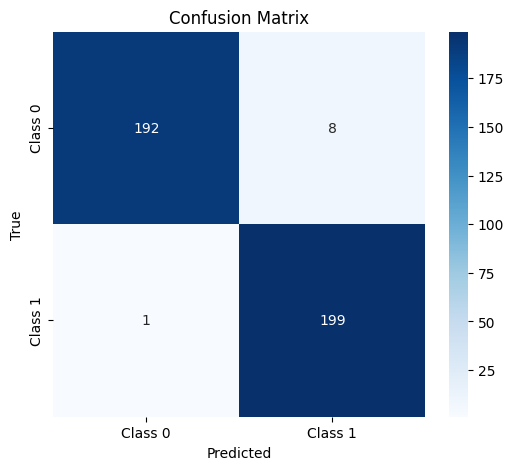

In [8]:
evaluate_on_test(model, test_loader)